In [14]:
import matplotlib.pyplot as pl
import seaborn
%matplotlib inline
import numpy as np
import netCDF4 as nc
import sys
import glob
import pickle
from matplotlib import rc

In [2]:
# determine progression of number of L2 files to load
# the progression is an incremental number of files not an absolute.
# could be a single number, e.g. 100 so that
# for each entry in that progression:
    # loop through that number of files:
        # read file names from a list
        # load and aggregate data
        # save a copy of the aggregated data
        # implement post-processing on that copy to reduce data to a single repr. value
    # when
    # Just continue looping and aggregating the data.

def GetStats(data,pasNum):
    datArrTemp = np.ma.sqrt(data/pasNum)
    median = np.ma.median(datArrTemp[(datArrTemp>0) & (datArrTemp < 1)])
    std = np.std(datArrTemp[(datArrTemp>0) & (datArrTemp < 1)])
    return median,std

def GetSilent(fname,bands):
    rrsSilDict = dict.fromkeys(bands)
    with nc.Dataset(fname) as dset:
        gv= dset.groups['geophysical_data'].variables
        for band in bands:
            rrsSilDict[band] = gv['Rrs_'+band][:]
    return rrsSilDict

def GetRolStats(flist,bands,rrsSilDict):
    filecount = len(flist)
    aggDataDict = dict.fromkeys(bands)
    rollingStatsDict={b:np.empty((filecount,2)) for b in bands}
    firstPass = {b:True for b in bands}
    for i,f in enumerate(flist):
        with nc.Dataset(f) as dset:
            ngv = dset.groups['geophysical_data'].variables        
            for band in bands:
                rrsNoi_vvv = ngv['Rrs_' + band][:]
                if firstPass[band]:
                    aggDataDict[band] = (rrsNoi_vvv - rrsSilDict[band]) ** 2
                    firstPass[band] = False
                else:
                    aggDataDict[band] += (rrsNoi_vvv - rrsSilDict[band]) ** 2
                rollingStatsDict[band][i,0],rollingStatsDict[band][i,1] = GetStats(aggDataDict[band],i+1)
        print("\r%.1f%% --> working on %s" % (100.0 * (i+1)/filecount,f),end='',flush=True)
    return rollingStatsDict
    
def Main (argv):
    # program needs to be called with filename example as arg 1, 
    # number of files to profile, as arg. 2.
    print(argv[0])
    silentFile = argv[0]
    noisyDir = argv[1]
    plFind = '_silent'
    ext = '.L2'
    fBaseName = silentFile.split('/')[-1].split(plFind)[0]
    fPattern = noisyDir + fBaseName + '*' + ext
    flis = glob.glob(fPattern)
    saveName = argv[2]
    visBands = ['412','443','490','510','555','670']
    rsd = GetSilent(silentFile,visBands)
    rolStatsDict = GetRolStats(flis,visBands,rsd)
    print("\nSaving data...")
    pickle.dump(rolStatsDict,open(saveName,"wb"))   
    print("\rDone!")
    return rolStatsDict
#if __name__ == "__main__":
#    Main(sys.argv[1:])  

In [4]:
mainDir = '/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/'
mainfile = mainDir+'S1999229224418_silent.L2'
noisDir = mainDir + 'Noisy/'
Main([mainfile,noisDir,'convFullStd.p'])

/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/S1999229224418_silent.L2
100.0% --> working on /disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/Noisy/S1999229224418_noisy_1000.L2
Saving data...
Done!


In [30]:
def PlConvergSinglFrame(fname,savName):
    """
        RollingStatDict is a nx2 numpy array where n is the number
        of runs, the 0th column is accumulated median and the 1st column
        is accumulated stdev.
    """
    colDict = {'412':'#001166','443':'#004488','490':'#116688',
           '510':'#228844','555':'#667722','670':'#aa2211',
           '765':'#770500','865':'#440000'}
    rc('xtick',labelsize=16)
    rc('ytick',labelsize=16)
    rollingStatDict=pickle.load(open(fname,"rb"))
    fig,ax=pl.subplots(figsize=(8,6))
    bands=['412','443','490','510','555','670']
    for band in bands:
        data= rollingStatDict[band][:,1]
        minData = data.min()
        maxData = data.max()
        percData = (data - minData) / (maxData - minData) * 100
        ax.plot(np.arange(1,len(data)+1),percData,label=band,color=colDict[band])
        ax.legend(loc='best',fontsize=16)

        #axs[i,j].set_ylim(ymin=data.min() - 0.02*data.min())
        #axs[i,j].set_xlim(xmin=-10,xmax=len(data)+10)
        ax.set_xlabel('iteration number',fontsize=16)
        ax.set_ylabel('cumulative uncertainty (% of range)',fontsize=16)
        ax.set_yscale('log')
    fig.savefig(savName)

In [20]:
def PlotConvergence(fname,savName):
    colDict = {'412':'#001166','443':'#004488','490':'#116688',
           '510':'#228844','555':'#667722','670':'#aa2211',
           '765':'#770500','865':'#440000'}
    rStDict=pickle.load(open(fname,"rb"))
    fig,axs=pl.subplots(nrows=3,ncols=2,figsize=(12,12))
    bands=['412','443','490','510','555','670']
    reshBands=np.reshape(bands,(3,2))
    for i in range(3):
        for j in range(2):
            data= rStDict[reshBands[i,j]][:,1]
            minData = data.min()
            maxData = data.max()
            percData = (data - minData) / (maxData - minData) * 100
            if singleGraph:
            else:
                axs[i,j].plot(np.arange(1,len(data)+1),percData,label=reshBands[i,j])
                axs[i,j].legend()
            
            #axs[i,j].set_ylim(ymin=data.min() - 0.02*data.min())
            #axs[i,j].set_xlim(xmin=-10,xmax=len(data)+10)
            if i == 2:
                axs[i,j].set_xlabel('iteration number')
            if j == 0:
                axs[i,j].set_ylabel('std. dev., aggregate uncertainty')
    fig.savefig('./SanityDataFigs/'+savName)

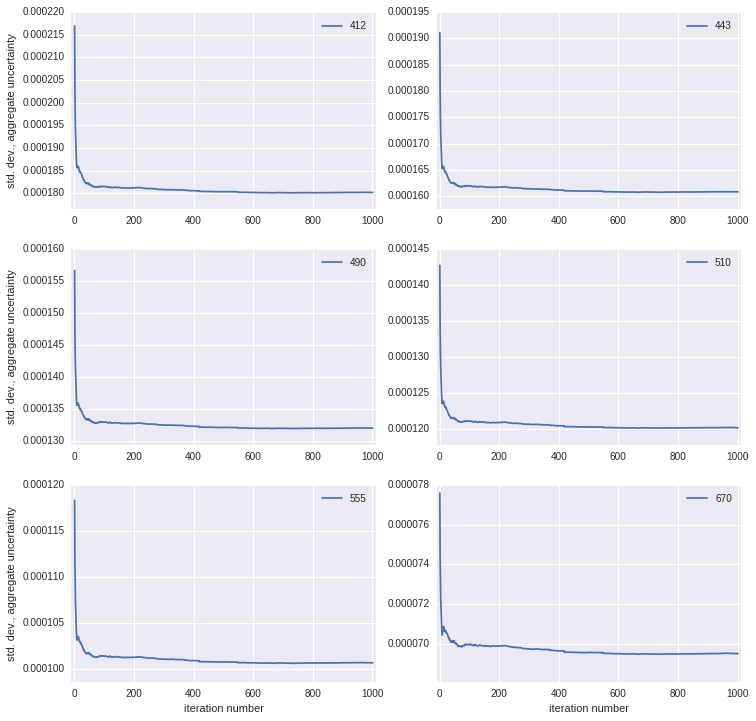

In [18]:
PlotConvergence('convFullStd.p','ConvergenceFullStandard.png')

In [19]:
mainVisDir = '/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/VisOnly/'
mainVisfile = mainDir+'S1999229224418_silent.L2'
noisDir = mainDir + 'Noisy/'
Main([mainfile,noisDir,'convFullVis.p'])

/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/S1999229224418_silent.L2
100.0% --> working on /disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/Noisy/S1999229224418_noisy_1000.L2
Saving data...
Done!


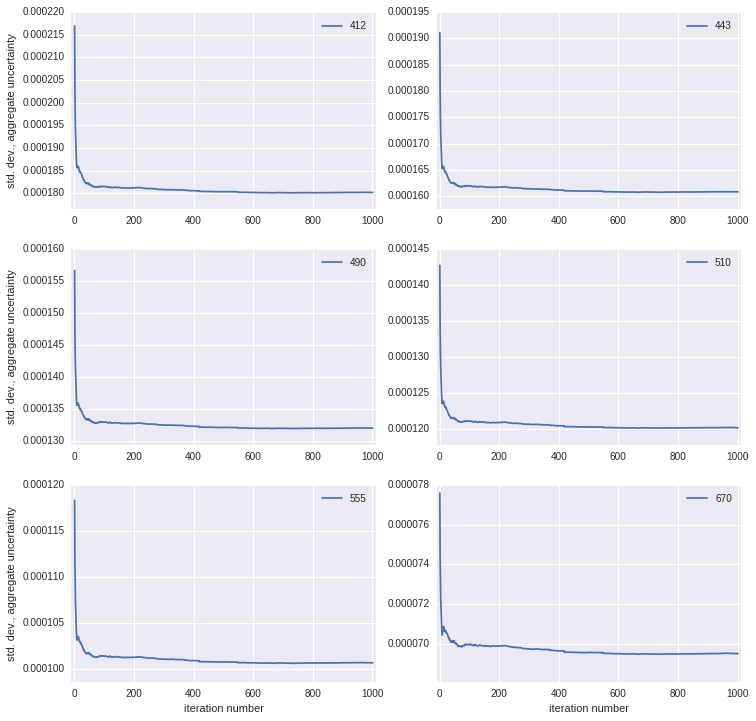

In [21]:
PlotConvergence('convFullVis.p','ConvergenceFullVisOnly.png')

### Convergence graph for SWF (poster)

In [25]:
mainVisDir = '/disk02/UNCERTAINTIES/Monte-Carlo/SWF/DATA/L2_L3/CentralPacific/Standard/'
mainVisfile = mainDir+'S1999229224418_silent.L2'
noisDir = mainDir + 'Noisy/'
Main([mainfile,noisDir,'convSWFVis.p'])

/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/S1999229224418_silent.L2
100.0% --> working on /disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/Standard/Noisy/S1999229224418_noisy_1000.L2
Saving data...
Done!


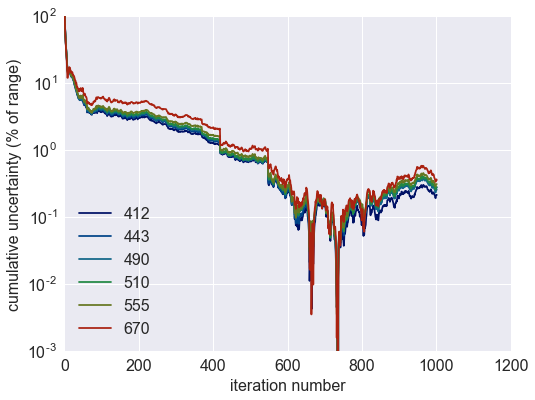

In [31]:
PlConvergSinglFrame('../pickles/convSWFStd.p','../figs/ConvergenceSWFStd.png')